In [42]:
# %%
# Configuration projet BigQuery
PROJECT_ID = "gen-lang-client-0861341623"
DATASET_ID = "penguins_dataset"
TABLE_ID = "penguins"

# %%
# Import de BigFrames (pandas-like mais lazy sur BigQuery)
import bigframes.pandas as bpd

# Toujours fermer une éventuelle session existante pour repartir propre
bpd.close_session()

# %%
# Charger une table depuis BigQuery en BigFrames
query_or_table = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"
bq_df = bpd.read_gbq(query_or_table)
# ⚠️ Ici, rien n’est exécuté côté BigQuery tant qu’on ne fait pas .to_pandas() ou autre commande qui nécessiterait que le traitement soit effectué

In [ ]:
#Cet affichage déclenche le job
bq_df


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo penguin (Pygoscelis papua),Biscoe,45.2,16.4,223.0,5950.0,MALE
1,Gentoo penguin (Pygoscelis papua),Biscoe,46.5,14.5,213.0,4400.0,FEMALE
2,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.7,16.0,183.0,3075.0,FEMALE
3,Gentoo penguin (Pygoscelis papua),Biscoe,46.4,15.6,221.0,5000.0,MALE
4,Gentoo penguin (Pygoscelis papua),Biscoe,46.1,13.2,211.0,4500.0,FEMALE
5,Adelie Penguin (Pygoscelis adeliae),Torgersen,43.1,19.2,197.0,3500.0,MALE
6,Gentoo penguin (Pygoscelis papua),Biscoe,45.2,15.8,215.0,5300.0,MALE
7,Adelie Penguin (Pygoscelis adeliae),Dream,36.2,17.3,187.0,3300.0,FEMALE
8,Chinstrap penguin (Pygoscelis antarctica),Dream,46.0,18.9,195.0,4150.0,FEMALE
9,Gentoo penguin (Pygoscelis papua),Biscoe,54.3,15.7,231.0,5650.0,MALE


In [ ]:
# Calcul : moyenne du poids
average_body_mass = bq_df["body_mass_g"].mean()

In [7]:
print("Expression moyenne :", average_body_mass)

Expression moyenne : 4201.75438596491


In [9]:
# Groupby + mean + sort
heaviest_species = (
    bq_df["body_mass_g"]
    .groupby(by=bq_df["species"])
    .mean()
    .sort_values(ascending=False)
)

In [ ]:
# Dry run : on estime le coût du SQL généré si jamais il était exécuté 
heaviest_species.to_pandas(dry_run=True)

columnCount                                                            1
columnDtypes                                    {'body_mass_g': Float64}
indexLevel                                                             1
indexDtypes                                                     [string]
bigquerySchema         [SchemaField('bfuid_col_23', 'STRING', 'NULLAB...
projectId                                     gen-lang-client-0861341623
location                                                              US
jobType                                                            QUERY
dispatchedSql          SELECT\n`bfuid_col_23` AS `bfuid_col_23`,\n`bf...
destinationTable       {'projectId': 'gen-lang-client-0861341623', 'd...
useLegacySql                                                       False
referencedTables       [{'projectId': 'gen-lang-client-0861341623', '...
totalBytesProcessed                                                15624
cacheHit                                           

In [11]:
#15600 bytes processed, c'est insignifiant, on exécute la requête !
heaviest_species.to_pandas()

species
Gentoo penguin (Pygoscelis papua)             5076.01626
Chinstrap penguin (Pygoscelis antarctica)    3733.088235
Adelie Penguin (Pygoscelis adeliae)          3700.662252
Name: body_mass_g, dtype: Float64

In [13]:
# %%
# Ajouter une colonne calculée "message"
bq_with_message = bq_df.assign(
    message="Bonjour, je suis un pingouin de l'espèce : " + bq_df['species']
)

# Sauvegarder dans une nouvelle table BigQuery
bq_with_message.to_gbq(f"{PROJECT_ID}.{DATASET_ID}.penguins_with_message", if_exists="replace")

# Export possible en CSV 
bq_with_message.to_csv("penguins.csv")


<Axes: ylabel='Frequency'>

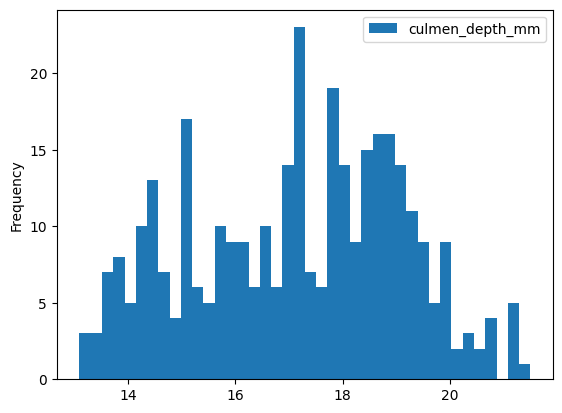

In [14]:
# Histogramme direct depuis BigFrames
bq_df["culmen_depth_mm"].plot.hist(bins=40)


In [ ]:
# Catégorisation simple
true_df = bpd.concat([
    bq_df[bq_df["culmen_depth_mm"] < 17].assign(culmen_depth_category="small"),
    bq_df[bq_df["culmen_depth_mm"] >= 17].assign(culmen_depth_category="big")
]).to_pandas()

# On fait .to_pandas() pour ramener tout côté client. Si le jeu de données est trop volumineux => Plantera 
true_df.head()


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,culmen_depth_category
0,Gentoo penguin (Pygoscelis papua),Biscoe,45.2,16.4,223.0,5950.0,MALE,small
1,Gentoo penguin (Pygoscelis papua),Biscoe,46.5,14.5,213.0,4400.0,FEMALE,small
2,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.7,16.0,183.0,3075.0,FEMALE,small
3,Gentoo penguin (Pygoscelis papua),Biscoe,46.4,15.6,221.0,5000.0,MALE,small
4,Gentoo penguin (Pygoscelis papua),Biscoe,46.1,13.2,211.0,4500.0,FEMALE,small


In [16]:
# Binning du poids automatique
body_mass_g_bin = bpd.cut(bq_df["body_mass_g"], bins=3, labels=["bad", "medium", "good"])
bq_df = bq_df.assign(body_mass_g_category=body_mass_g_bin)
bq_df.head()


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,body_mass_g_category
0,Gentoo penguin (Pygoscelis papua),Biscoe,45.2,16.4,223.0,5950.0,MALE,good
1,Gentoo penguin (Pygoscelis papua),Biscoe,46.5,14.5,213.0,4400.0,FEMALE,medium
2,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.7,16.0,183.0,3075.0,FEMALE,bad
3,Gentoo penguin (Pygoscelis papua),Biscoe,46.4,15.6,221.0,5000.0,MALE,medium
4,Gentoo penguin (Pygoscelis papua),Biscoe,46.1,13.2,211.0,4500.0,FEMALE,medium


In [57]:
# Cast avec errors="null" -> les échecs deviennent NULL
species_as_string = bq_df["species"].astype("string", errors="null")
all_ok = species_as_string.notnull().all()
print("Toutes les valeurs convertibles ?", bool(all_ok))


Toutes les valeurs convertibles ? True


In [58]:
# Cast "sex" en string
sex_as_str = bq_df["sex"].astype("string", errors="null")

# Les lignes qui ont échoué
failed_sex = bq_df[sex_as_str.isnull()]

failed_sex


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
10,Adelie Penguin (Pygoscelis adeliae),Torgersen,34.1,18.1,193.0,3475.0,<NA>
116,Adelie Penguin (Pygoscelis adeliae),Torgersen,<NA>,<NA>,<NA>,<NA>,<NA>
133,Gentoo penguin (Pygoscelis papua),Biscoe,<NA>,<NA>,<NA>,<NA>,<NA>
152,Adelie Penguin (Pygoscelis adeliae),Dream,37.5,18.9,179.0,2975.0,<NA>
164,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,14.3,216.0,4100.0,<NA>
189,Adelie Penguin (Pygoscelis adeliae),Torgersen,37.8,17.3,180.0,3700.0,<NA>
223,Gentoo penguin (Pygoscelis papua),Biscoe,47.3,13.8,216.0,4725.0,<NA>
232,Adelie Penguin (Pygoscelis adeliae),Torgersen,42.0,20.2,190.0,4250.0,<NA>
243,Adelie Penguin (Pygoscelis adeliae),Torgersen,37.8,17.1,186.0,3300.0,<NA>
328,Gentoo penguin (Pygoscelis papua),Biscoe,46.2,14.4,214.0,4650.0,<NA>


In [ ]:
# Cast avec errors="null" -> les échecs deviennent NULL
species_as_string = bq_df["sex"].astype("string", errors="null")
all_ok = species_as_string.notnull().all()
print("Toutes les valeurs convertibles ?", bool(all_ok))
